In [297]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table

In [2]:
from   desimodel.focalplane  import get_tile_radius_deg 

In [3]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [4]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf
    dat   = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')    
    
    return dat

In [5]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [6]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [7]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [12]:
def get_clauds(imaging_bit=1, field='COSMOS'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']
    
    clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/October2020/{}_v3_v201026.fits'.format(field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]
    
    return  clauds[field], areas[field]

In [13]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [10]:
# hiz  = laigle()

In [11]:
# kids = get_kids()

In [12]:
# splash = get_splash()

In [13]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [14]:
# hilde  = get_hildebrandt()

In [15]:
# grush  = get_goldrush()

In [16]:
# laes   = get_laes()

In [17]:
# cfhtls = get_cfhtls_wide()

In [18]:
# vvds   = get_vvds()

In [14]:
clauds, area = get_clauds()

In [16]:
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.31573,7.50047,7.48196,6.54335,0.0,0,0.8746
2,149.51906824547063,2.878

In [18]:
# hilde

In [19]:
# grush_D2 = grush[(grush['ra'] > 148.) & (grush['ra'] < 152.0) & (grush['dec'] > 0.00) & (grush['dec'] < 4.5)]

In [17]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [23]:
tileids = np.unique(indx)

In [21]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [19]:
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [293]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

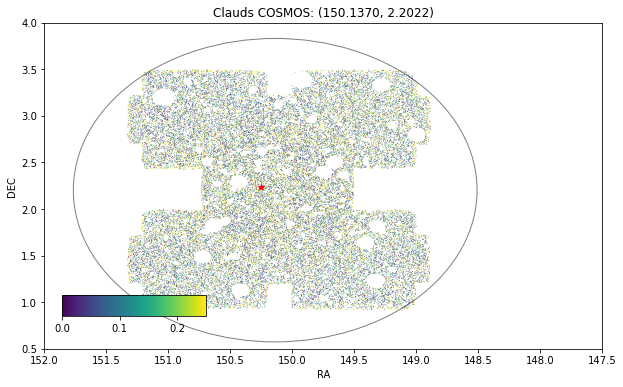

In [296]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('clauds_field.pdf')

In [24]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [25]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [27]:
udrops    = clauds[liu_udrops(clauds)]

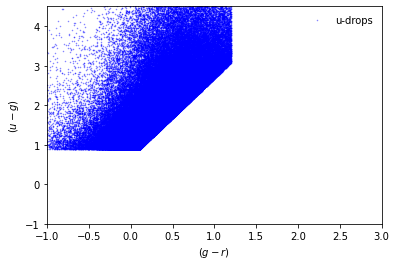

In [31]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('clauds-udrop-color-selection.pdf')

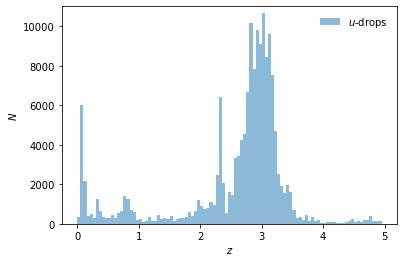

In [32]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist( udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [33]:
zmax       = 1.5
interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

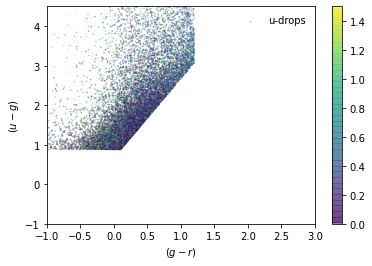

In [34]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

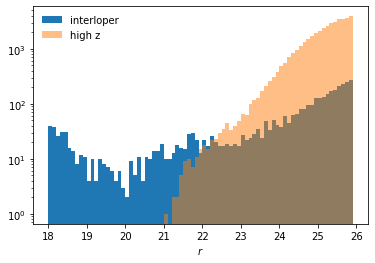

In [35]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')

pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [54]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=18., maglim=26.)]

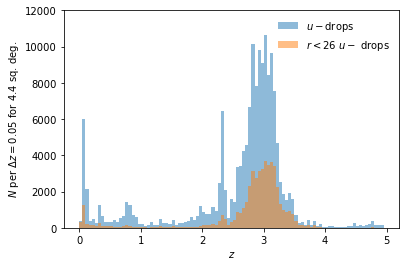

In [57]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('clauds-udrop-redshift-distribution.pdf')

# Number per sq. degree

In [44]:
len(rlim_udrops), area['u']

(49027, 4.41)

In [48]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 11117.23


In [145]:
print('u-dropout interloper fraction of {:.3f}'.format(np.count_nonzero(rlim_udrops['ZPHOT'] < 0.1) / len(rlim_udrops)))

u-dropout interloper fraction of 0.018


In [362]:
def flatmagcat(maglimcat, band, maglim=26.01):
    bins       = np.arange(21., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    magsampling                    = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]

    print('{:.1f} \t {:d}'.format(cutlim, np.count_nonzero(maglimcat['ISIN'])))
        
    # In, residual.
    return  maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

22.2 	 2226
23.5 	 3917
24.1 	 8122
24.4 	 6770
24.6 	 4877
24.8 	 5013
25.0 	 3869
25.1 	 2476
25.2 	 1788
25.3 	 1404

-------------------------

40462 	 49027


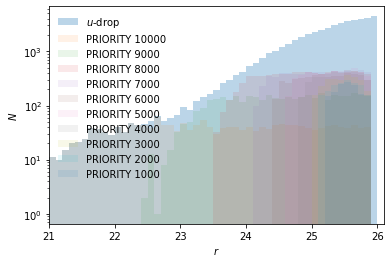

In [286]:
bins = np.arange(21., 26.1, 0.1)
result = pl.hist(rlim_udrops['r'], bins=bins, alpha=0.3, label=r'$u$-drop')
reducecat = Table(rlim_udrops, copy=True)

tiers = Table()
total =  0

for i in np.arange(10):    
    priority                = 10000 - i * 1000
        
    flat_udrops, reducecat  = flatmagcat(reducecat, 'r')
    result                  = pl.hist(flat_udrops['r'], bins=bins, alpha=0.1, label='PRIORITY {}'.format(priority))
        
    flat_udrops['PRIORITY'] = priority
    tiers                   = vstack((tiers, flat_udrops))
    
    total                  += len(flat_udrops)
    
print('\n-------------------------\n')
print('{} \t {}'.format(total, len(rlim_udrops)))

pl.xlim(21., 26.1)

pl.xlabel(r'$r$')
pl.ylabel(r'$N$')

pl.yscale('log')

pl.legend(frameon=False)

pl.savefig('clauds-udrop-magnitude-distribution.pdf')

In [376]:
isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

tiers['TILEID']       = tiles['TILEID'][indx]

tiers['SAMPLE']       = 'CLAUDS-U'
tiers['TARGETID']     = np.arange(len(tiers))
tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

tiers.meta['EXTNAME'] = 'MTL'

del tiers['ISIN']

tiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/udrops.fits', format='fits', overwrite=True)

tiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,r-i,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str8,int64,float64,float32,float32,float32,float32
1636,149.43524372702117,2.8941611712399,10054,"0,0",0,7,True .. False,0.0001222763,0.000108878965,4.0,-34.686806,1.1231841,0.10967404,0.017933548916712134,0.00032001463,24.902279,0.7376734614372253,0.88923234,1.2879984,1.6499468,26.765,27.047,26.473,25.274,25.18,24.773,25.673,-99.022,-99.016,-99.01,-99.007,0.138,0.243,0.102,0.054,0.062,0.064,0.37,-99.0,-99.0,-99.0,-99.0,27.05815,27.230331,26.785797,25.516016,25.416212,25.02298,26.064865,1e+20,1e+20,1e+20,1e+20,0.14010248,0.22304995,0.1068166,0.053611416,0.06231785,0.06578155,0.43450108,1e+20,1e+20,1e+20,1e+20,127.0,-13.858,-14.268,-14.898,-15.114,-15.986,-16.401,-16.588,-16.745,-16.818,-16.831,-16.846,-16.976,-16.796,-99.0,0.383,0.3481,0.4073,7,8.03287,32.2535,8.59736,26,89,1,0.3787,0.341,0.4131,-99.0,0.38,10,321031000.0,0.2,1,1841880000.0,7.91944,7.74914,7.76494,8.11043,-1.32943,-1.46159,-1.6612,-0.922895,-9.24636,-9.21073,-9.7235,-8.74655,7.72081,7.7023,6.76369,0.0,0,0.3787,0.0940000000000012,1.198999999999998,10000,11155,CLAUDS-U,0,0.8454389540702307,0.0,0.0,0.0,0.0
15838,149.4403418886956,3.031629176732145,10054,"0,0",0,7,True .. False,0.00014080024,9.021241e-05,4.0033565,83.85179,1.5606003,0.35922092,0.021927645200373873,0.0006759758,25.421326,0.6643256545066833,1.2003654,1.742342,2.220392,30.415,-99.102,27.509,25.681,25.104,24.887,25.43,-99.027,-99.019,-99.012,-99.008,5.176,-99.0,0.364,0.093,0.073,0.092,0.377,-99.0,-99.0,-99.0,-99.0,30.606243,99.0,28.51637,26.454401,25.720041,25.586437,26.154919,1e+20,1e+20,1e+20,1e+20,3.6425478,99.0,0.55478144,0.11726343,0.08084609,0.111074366,0.46376428,1e+20,1e+20,1e+20,1e+20,125.0,-20.914,-21.289,-21.705,-21.815,-22.151,-22.354,-22.531,-22.679,-22.75,-22.769,-22.846,-22.935,-22.683,-99.0,3.7307,3.5214,4.2285,

# BX selection

In [250]:
def bx(cat, rmin=22., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))
    
    return  isin

In [251]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

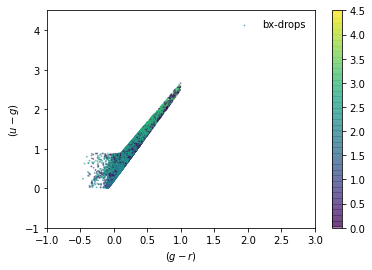

In [252]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

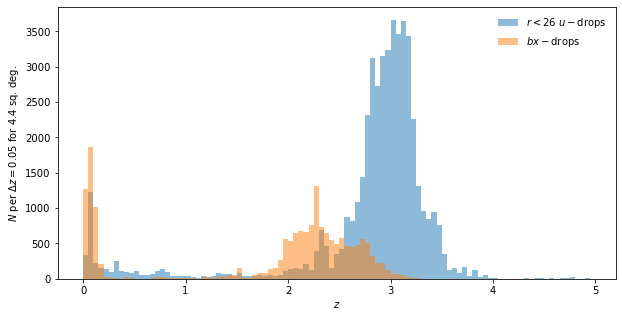

In [253]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
axes.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [254]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3970.75


In [255]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [256]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 12.786


Text(0, 0.5, '$(u-g)$')

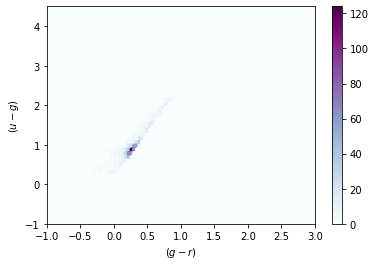

In [257]:
plt.hexbin(bx_interlopers['g'] - bx_interlopers['r'], bx_interlopers['u'] - bx_interlopers['g'], label='bx-drops', extent=[-1., 3., -1., 4.5], cmap='BuPu')
pl.colorbar()

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

In [259]:
len(bx_clauds), len(bx_interlopers)

(17511, 2239)

21.0 	 3064
22.6 	 880
23.1 	 1679
23.4 	 1793
23.6 	 1762
23.7 	 1381
23.8 	 973
23.9 	 854
24.0 	 720

-------------------------

13106 	 17511


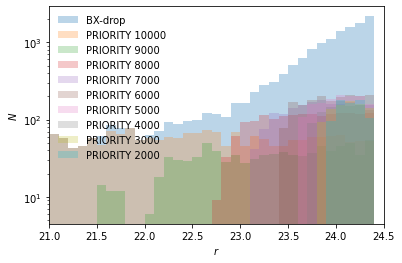

In [388]:
bins = np.arange(21., 24.5, 0.1)
result = pl.hist(bx_clauds['r'], bins=bins, alpha=0.3, label=r'BX-drop')
reducecat = Table(bx_clauds, copy=True)

tiers = Table()
total =  0

for i in np.arange(9):    
    priority                = 10000 - i * 1000
        
    flat_bxdrops, reducecat = flatmagcat(reducecat, 'r', maglim=24.51)
    result                  = pl.hist(flat_bxdrops['r'], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
        
    flat_bxdrops['PRIORITY'] = priority
    tiers                   = vstack((tiers, flat_bxdrops))
    
    total                  += len(flat_bxdrops)
    
print('\n-------------------------\n')
print('{} \t {}'.format(total, len(bx_clauds)))

pl.xlim(21., 24.5)

pl.xlabel(r'$r$')
pl.ylabel(r'$N$')

pl.yscale('log')

pl.legend(frameon=False)

pl.savefig('clauds-bxdrop-magnitude-distribution.pdf')

In [389]:
isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

tiers['TILEID']       = tiles['TILEID'][indx]

tiers['SAMPLE']       = 'CLAUDS-BX'
tiers['TARGETID']     = np.arange(len(tiers))
tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

tiers.meta['EXTNAME'] = 'MTL'

del tiers['ISIN']

tiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/bxdrops.fits', format='fits', overwrite=True)

tiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
1163,149.51144255922006,2.8863232132097987,10054,"0,0",0,7,True .. False,0.0003101514,0.00023002054,4.0,40.14685,1.3481488,0.25824213,0.0169516723932009,0.00063610286,23.188837,0.02773100696504116,2.2467184,3.3881872,4.40153,23.097,23.031,22.161,21.847,21.65,21.564,21.467,-99.021,-99.015,-99.01,-99.006,0.012,0.014,0.005,0.006,0.005,0.008,0.016,-99.0,-99.0,-99.0,-99.0,24.098652,24.09217,23.146397,22.735338,22.513407,22.3893,22.393408,1e+20,1e+20,1e+20,1e+20,0.009036499,0.011199202,0.0041292915,0.0042005884,0.0039348803,0.0055603688,0.012420296,1e+20,1e+20,1e+20,1e+20,127.0,-14.172,-14.116,-14.774,-14.968,-15.544,-15.806,-15.983,-16.096,-16.136,-16.144,-16.149,-16.223,-15.917,-99.0,0.0959,0.0904,0.104,7,2.7359,85.2326,16.049,29,60,28,0.0756,0.0515,0.1069,-99.0,0.7,4,3500000000.0,0.0,0,2883560000.0,7.78375,7.8268,7.55106,7.99036,-1.7699,-1.90121,-1.94915,-1.50322,-9.46673,-9.72802,-9.81694,-9.25408,7.05451,7.2953,6.49419,0.0,0,0.0756,0.9359999999999999,0.31400000000000006,10000,11155,CLAUDS-BX,0,0.04545321802540747,0.0,0.0,0.0,0.0
2929,149.42348671113297,2.9049086915282496,10054,"0,0",0,7,True .. False,0.00018341345,0.00017864289,4.0,-32.541237,1.0268358,0.026134431,0.018185032623509203,0.00016424312,19.33594,0.9818268418312072,0.8288854,1.2694687,1.6374879,22.54,22.217,20.813,20.159,19.915,19.781,19.688,-99.022,-99.016,-99.01,-99.007,0.007,0.007,0.002,0.001,0.001,0.002,0.004,-99.0,-99.0,-99.0,-99.0,22.776815,22.538916,21.090607,20.37289,20.09377,19.913177,19.903662,1e+20,1e+20,1e+20,1e+20,0.0027198715,0.0029398585,0.0008439803,0.0006096348,0.00055657845,0.00067721837,0.0015770439,1e+20,1e+20,1e+20,1e+20,127.0,-10.107,-13.123,-15.785,-16.095,-17.132,-17.687,-17.847,-17.995,-18.088,-18.121,-18.22,-18.435,-

# GOLDRUSH g-dropouts

In [335]:
# root = '/global/cscratch1/sd/mjwilson/GOLDRUSH/DESILBG/catalog_hsc_S16A_dropouts/'
# cols = open(root + 'column.cat', 'r')
# names = [x.replace('\n','').split(' ')[-1] for x in cols.readlines()]

In [336]:
# gdrops = Table.read(root + 'exill_blendedness_selected_upper_-0.7_SNcutted_gri_D_COSMOS.cat', format='ascii', names=names)
# ud_gdrops = Table.read(root + 'exill_blendedness_selected_upper_-0.7_SNcutted_gri_UD_COSMOS.cat', format='ascii', names=names)

In [331]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [367]:
def gdrop(cat, imin=18., imax=26., intercept=1.3):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
        
    return  isin

In [368]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,r-i,g-r
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941,0.31099999999999994,-0.23000000000000043
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.3157

In [369]:
gdrops = clauds_hsc[gdrop(clauds_hsc, imin=0.)]
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=26.)]

No handles with labels found to put in legend.


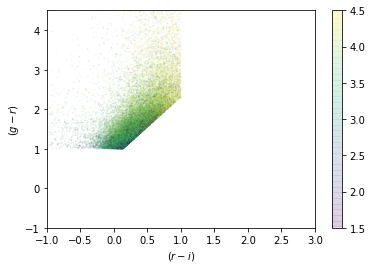

In [370]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

pl.legend(frameon=False)

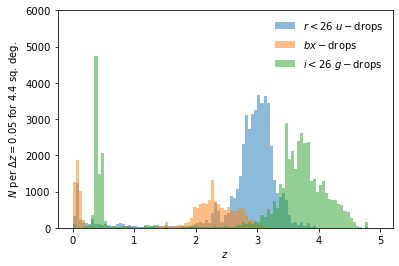

In [371]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$bx-$drops')
pl.hist(ilim_gdrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$i<26 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [372]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / area['g']))

Target density of g-dropouts per sq. deg. is 6003.70


In [373]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BEST'] < 0.1) / len(ilim_gdrops)))

g-drop interloper percentage of 0.206


22.4 	 1180
23.7 	 4341
24.2 	 5547
24.5 	 6183
24.7 	 5114

-------------------------

22365 	 47069


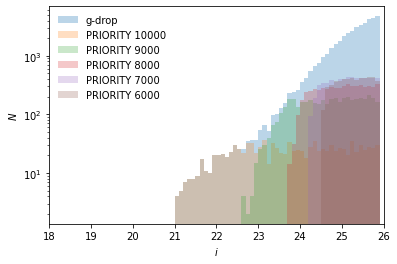

In [390]:
bins = np.arange(21., 26.0, 0.1)
result = pl.hist(ilim_gdrops['i'], bins=bins, alpha=0.3, label=r'g-drop')
reducecat = Table(ilim_gdrops, copy=True)

tiers = Table()
total =  0

for i in np.arange(5):    
    priority               = 10000 - i * 1000
        
    flat_gdrops, reducecat = flatmagcat(reducecat, 'i', maglim=26.01)
    result                 = pl.hist(flat_gdrops['i'], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
        
    flat_gdrops['PRIORITY'] = priority
    tiers                   = vstack((tiers, flat_gdrops))
    
    total                  += len(flat_gdrops)
    
print('\n-------------------------\n')
print('{} \t {}'.format(total, len(ilim_gdrops)))

pl.xlim(18., 26.0)

pl.xlabel(r'$i$')
pl.ylabel(r'$N$')

pl.yscale('log')

pl.legend(frameon=False)

pl.savefig('clauds-gdrop-magnitude-distribution.pdf')

In [391]:
isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

tiers['TILEID']       = tiles['TILEID'][indx]

tiers['SAMPLE']       = 'CLAUDS-G'
tiers['TARGETID']     = np.arange(len(tiers))
tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

tiers.meta['EXTNAME'] = 'MTL'

del tiers['ISIN']

tiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/gdrops.fits', format='fits', overwrite=True)

tiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,r-i,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str8,int64,float64,float32,float32,float32,float32
2214,149.4554984553073,2.901427742610668,10054,"0,0",0,7,True .. False,7.640609e-05,5.4926586e-05,4.5364075,60.679405,1.3907089,0.28094226,0.01808195416534953,0.00038764093,25.05562,0.5771737098693848,0.85001385,1.2072065,1.5080696,30.596,28.545,28.137,26.108,25.475,25.124,25.236,-99.022,-99.016,-99.01,-99.007,2.73,0.481,0.252,0.063,0.044,0.047,0.13,-99.0,-99.0,-99.0,-99.0,33.86569,28.087103,28.399385,26.221197,25.624065,25.189589,25.273737,1e+20,1e+20,1e+20,1e+20,43.64672,0.24822764,0.25659114,0.056456577,0.04123863,0.04107241,0.111989655,1e+20,1e+20,1e+20,1e+20,127.0,-20.526,-20.939,-21.381,-21.481,-21.737,-21.88,-22.024,-22.137,-22.184,-22.192,-22.218,-22.242,-21.931,-99.0,3.9312,3.6238,4.1752,7,3.20424,9.98827,2.83024,26,102,8,3.962,3.6663,4.136,0.38,3.72,3,50000000.0,0.3,2,297808000.0,10.4153,9.58445,9.93161,10.8814,1.94655,1.95101,1.74173,2.37059,-8.39558,-7.63344,-8.8929,-7.88688,10.7017,10.1335,9.03889,0.0,0,3.962,0.6329999999999991,2.029,10000,11155,CLAUDS-G,0,0.4027448848189472,0.0,0.0,0.0,0.0
2779,149.5626193466604,2.9055437287421304,10054,"0,0",0,7,True .. False,0.0012689697,0.00012174545,4.680089,0.8762381,10.429489,0.90411806,0.016918676724306976,0.0023594985,25.886974,0.00692288763821125,17.271652,76.91596,73.78746,26.194,-99.079,23.867,22.833,23.816,22.872,23.145,-99.02,-99.015,-99.01,-99.006,0.386,-99.0,0.042,0.026,0.08,0.045,0.122,-99.0,-99.0,-99.0,-99.0,28.415552,99.0,26.934353,26.045422,27.158266,25.940683,25.898632,1e+20,1e+20,1e+20,1e+20,0.52656883,99.0,0.12544192,0.08764264,0.3073778,0.13917638,0.2813848,1e+20,1e+20,1e+20,1e+20,125.0,-22.062,-22.59,-22.157,-22.164,-22.026,-21.743,-21.582,-21.553,-21.528,-21.516,-21.403,-21.357,-21.054,-99.0,3.5689,3.5405,3.6108,6,89.8533,142.974,

# Done.